In [2]:
!pip install -r requirements.txt

Looking in indexes: https://build-nexus.prod.crto.in/repository/moab.pypi/simple
     |################################| 693 kB 3.5 MB/s eta 0:00:01
     |################################| 1.3 MB 68.2 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |################################| 12.7 MB 3.7 MB/s eta 0:00:01
     |################################| 142 kB 92.4 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  ERROR: Command errored out with exit status 1:
   command: /home/a.betlei/.local/share/jupyter/.python-kernel/python-kernel-54945/bin/python /home/a.betlei/.local/share/jupyter/.python-kernel/python-kernel-54945/lib64/python3.6/site-packages/pip/_vendor/pep517/in_process/_in_process.py get_requires_for_build_wheel /tmp/tmpolvsjaie
       cwd: /tmp/pip-install-e2s9m3cv/ecos_8a0f4bc4649f47048ccbcde36f65c86d
  Complete output 

In [ ]:
!pip install --upgrade pip
!pip install --upgrade "jax[cpu]"

In [5]:
import math
import numpy as np
import pandas as pd
import matplotlib
import scipy.integrate as integrate
from scipy.stats import norm
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.dpi'] = 100

import itertools
from tqdm import tqdm

import jax
jax.config.update('jax_platform_name', 'cpu')

import cvxpy as cvx

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
from aaai_helpers.optim import *
from aaai_helpers.jax_spm import *
from aaai_helpers.eval import *
from aaai_helpers.utils import *
from aaai_helpers.baselines import *

##### 1. __fixed__ mu and Sigma

__Large__ variance compared to mean

In [8]:
mu_0 = np.array([
    [2,1.9,0],
    [2,1,0],
    [2,1,0]
    ])

Sigma_mult = 1

Sigma_0 = Sigma_mult * np.array([
    [3,1,3],
    [3,1,3],
    [1,1,1]
])**2

nbucket, npol = mu_0.shape

### For each pair of (bucket, policy) create normal distributions with corresponding mu and Sigma - we will use it for evaluation.
y_bs = create_bs(mu_0, Sigma_0, nbucket, npol, size=1000000)

In [9]:
nbucket, npol

(3, 3)

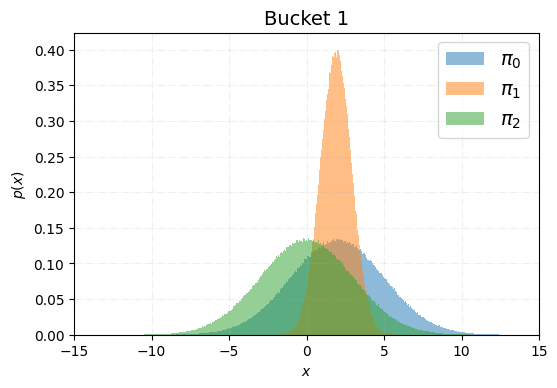

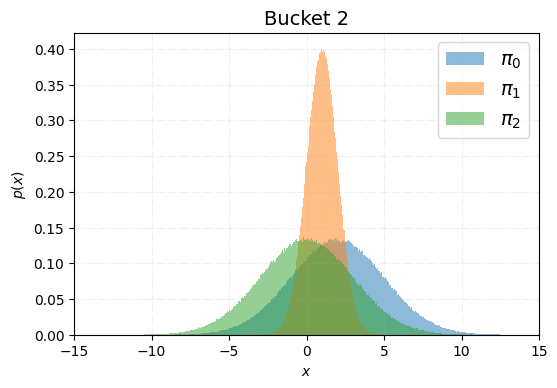

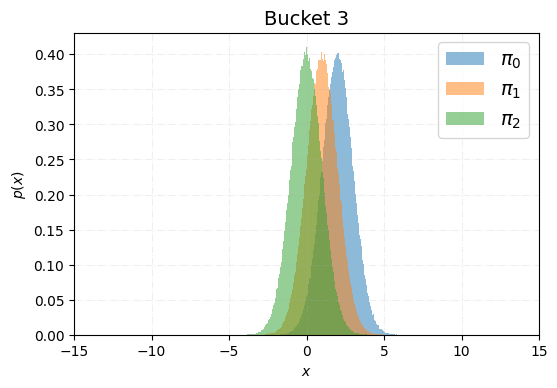

In [10]:
fontsize = 14

for b in range(nbucket):
    plt.figure()
    plt.hist(y_bs[b][0], bins=500, alpha=0.5, label='$\pi_0$', density=True)
    plt.hist(y_bs[b][1], bins=500, alpha=0.5, label='$\pi_1$', density=True)
    plt.hist(y_bs[b][2], bins=500, alpha=0.5, label='$\pi_2$', density=True)
    
    # plt.axvline(0, c='r', label='r')
    
    
    plt.xlabel('$x$')
    plt.ylabel('$p(x)$')
    plt.xlim(-15,15)
    plt.title('Bucket '+str(b+1), fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.grid(alpha=0.2, ls="-.")
    plt.show()

In [11]:
### for hard bruteforce
candidates = [list(comb) for comb in list(itertools.product([0., 1.], repeat=npol)) if sum(comb) == 1]
all_hard_allocs = list(itertools.product(candidates, repeat=nbucket))

### greedy allocation
greedy_alloc = greedy_1d(mu_0)

In [12]:
### Define r (success region) without AB test interpretation
Rs = np.arange(0., 7.1, 0.1)

methods = ['Bruteforce', 'Greedy1D', 'SuccessProbaMax']
res_1d = {i:np.zeros_like(Rs) for i in methods}

In [13]:
for i in tqdm(range(len(Rs))):
    
    hard_bf_alloc = hard_bruteforce_1d_v3(all_hard_allocs, mu_0, Sigma_0, Rs[i])
    res_1d['Bruteforce'][i] = evaluate_1d_v2(hard_bf_alloc, mu_0, Sigma_0, Rs[i])
    
    res_1d['Greedy1D'][i] = evaluate_1d_v2(greedy_alloc, mu_0, Sigma_0, Rs[i])
    
    ### initial allocation to start SPM from 
    psi_0 = np.array([[1./npol]*npol]*nbucket) ### uniform allocation
    # psi_0 = greedy_alloc
    
    spm_alloc = optimize_1d(Sigma_0, mu_0, Rs[i], psi_0, n_steps=10000, eta = 0.1)
    res_1d['SuccessProbaMax'][i] = evaluate_1d_v2(spm_alloc, mu_0, Sigma_0, Rs[i])

100%|██████████| 71/71 [00:08<00:00,  8.64it/s]


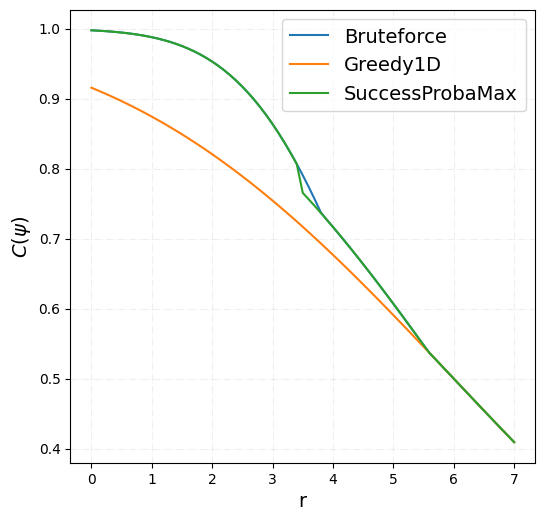

In [14]:
plt.figure(figsize=(6,6))
fontsize = 14

for m in methods:
    plt.plot(
        Rs,
        res_1d[m],
        label=m
    )
    
plt.xlabel('r', fontsize=fontsize)
plt.ylabel('$C(\psi)$', fontsize=fontsize)
plt.grid(alpha=0.2, ls="-.")
# plt.title('Test', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

__Small__ variance compared to mean

In [15]:
mu_0 = np.array([
    [2,1.9,0],
    [2,1,0],
    [2,1,0]
    ])

Sigma_mult = 0.01

Sigma_0 = Sigma_mult * np.array([
    [3,1,3],
    [3,1,3],
    [1,1,1]
])**2

nbucket, npol = mu_0.shape

### For each pair of (bucket, policy) create normal distributions with corresponding mu and Sigma - we will use it for evaluation.
y_bs = create_bs(mu_0, Sigma_0, nbucket, npol, size=1000000)

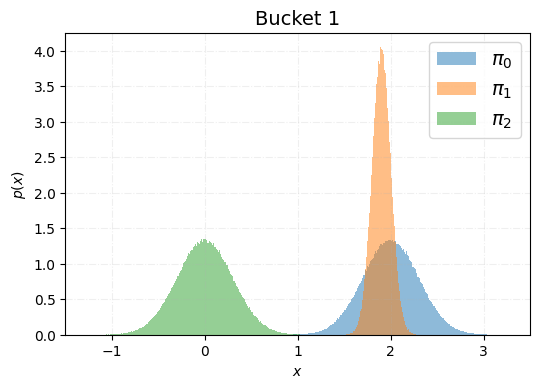

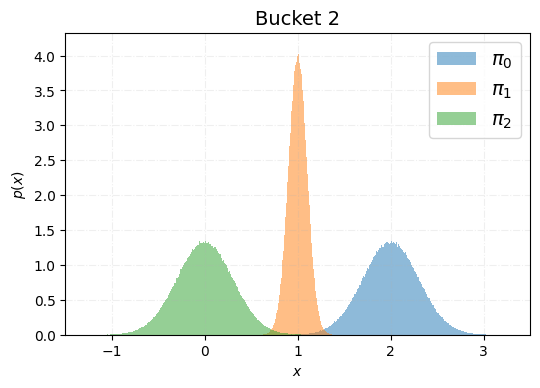

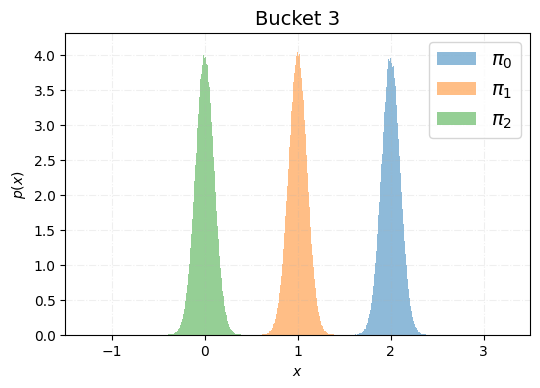

In [18]:
fontsize = 14

for b in range(nbucket):
    plt.figure()
    plt.hist(y_bs[b][0], bins=500, alpha=0.5, label='$\pi_0$', density=True)
    plt.hist(y_bs[b][1], bins=500, alpha=0.5, label='$\pi_1$', density=True)
    plt.hist(y_bs[b][2], bins=500, alpha=0.5, label='$\pi_2$', density=True)
    
    # plt.axvline(0, c='r', label='r')
    
    
    plt.xlabel('$x$')
    plt.ylabel('$p(x)$')
    plt.xlim(-1.5,3.5)
    plt.title('Bucket '+str(b+1), fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.grid(alpha=0.2, ls="-.")
    plt.show()

In [19]:
### for hard bruteforce
candidates = [list(comb) for comb in list(itertools.product([0., 1.], repeat=npol)) if sum(comb) == 1]
all_hard_allocs = list(itertools.product(candidates, repeat=nbucket))

### greedy allocation
greedy_alloc = greedy_1d(mu_0)

### psi_0s for SuccessProbaMax
psi_0s = jnp.array([random.dirichlet(random.PRNGKey(i*23563), np.ones(npol), shape=(nbucket,)) for i in range(50000)])

In [20]:
### Define r (success region) without AB test interpretation
Rs = np.arange(4.5, 7.1, 0.1)

methods = ['Bruteforce', 'Greedy1D', 'SuccessProbaMax \n($\psi_0^{unif}$)', 'SuccessProbaMax \n($\psi_0$ from exploration)']
res_1d = {i:np.zeros_like(Rs) for i in methods}

In [21]:
for i in tqdm(range(len(Rs))):
    
    hard_bf_alloc = hard_bruteforce_1d_v3(all_hard_allocs, mu_0, Sigma_0, Rs[i])
    res_1d['Bruteforce'][i] = evaluate_1d_v2(hard_bf_alloc, mu_0, Sigma_0, Rs[i])
    
    res_1d['Greedy1D'][i] = evaluate_1d_v2(greedy_alloc, mu_0, Sigma_0, Rs[i])
    
    ### initial allocation to start SPM from 
    
    
    psi_0 = np.array([[1./npol]*npol]*nbucket) ### uniform allocation
    spm_unif_alloc = optimize_1d(Sigma_0, mu_0, Rs[i], psi_0, n_steps=10000, eta = 0.1)
    # spm_alloc = optimize_1d_v2(Sigma_0, mu_0, Rs[i], psi_0s, n_steps=10000, eta = 0.1)
    res_1d['SuccessProbaMax \n($\psi_0^{unif}$)'][i] = evaluate_1d_v2(spm_unif_alloc, mu_0, Sigma_0, Rs[i])
    
    # psi_0 = greedy_alloc
    spm_expl_alloc = optimize_1d_v2(Sigma_0, mu_0, Rs[i], psi_0s, n_steps=10000, eta = 0.1)
    res_1d['SuccessProbaMax \n($\psi_0$ from exploration)'][i] = evaluate_1d_v2(spm_expl_alloc, mu_0, Sigma_0, Rs[i])

100%|██████████| 26/26 [00:04<00:00,  5.76it/s]


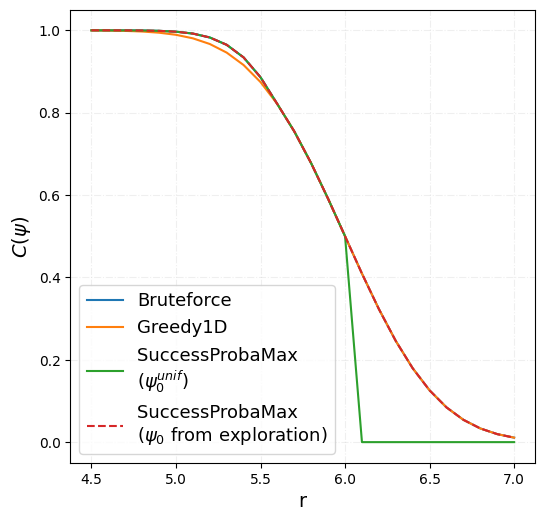

In [22]:
plt.figure(figsize=(6,6))
fontsize = 14

for m in methods[:-1]:
    plt.plot(
        Rs,
        res_1d[m],
        label=m
    )
    
plt.plot(
    Rs,
    res_1d[methods[-1]],
    label=methods[-1],
    ls="--"
)
    
plt.xlabel('r', fontsize=fontsize)
plt.ylabel('$C(\psi)$', fontsize=fontsize)
plt.grid(alpha=0.2, ls="-.")
# plt.title('Test', fontsize=fontsize)
plt.legend(fontsize=fontsize-1)#, bbox_to_anchor=(0.5, 1.02), framealpha=1)
plt.show()

##### 2. __estimated__ mu and sigma

__Large__ variance compared to mean

In [338]:
mu_0 = np.array([
    [2,1.9,0],
    [2,1,0],
    [2,1,0]
    ])

Sigma_mult = 1

Sigma_0 = Sigma_mult * np.array([
    [3,1,3],
    [3,1,3],
    [1,1,1]
])**2

nbucket, npol = mu_0.shape

np.random.seed(2480947)
    
N = 1000

df_sim = pd.DataFrame(
    {
        'X':np.random.choice(np.arange(nbucket), p=[1/3,1/3,1/3], size=N),
        'pi':np.random.choice(np.arange(npol), p=[1/3,1/3,1/3], size=N),
        'y':np.zeros(N)
    }
)

for i in range(N):
    df_sim['y'][i] = np.random.normal(mu_0[df_sim.X[i]][df_sim.pi[i]], np.sqrt(Sigma_0[df_sim.X[i]][df_sim.pi[i]]))

splits_res_train = []
splits_res_test = []
n_splits = 100

for _ in tqdm(range(n_splits)):


    df_sim = df_sim.sample(frac=1)
    df_sim_train = df_sim[:int(N/2)]
    df_sim_test = df_sim[int(N/2):]

    mu_0_train = df_sim_train.groupby(['X','pi']).mean().values.reshape(3,3)
    Sigma_0_train = df_sim_train.groupby(['X','pi']).var().values.reshape(3,3)

    mu_0_test = df_sim_test.groupby(['X','pi']).mean().values.reshape(3,3)
    Sigma_0_test = df_sim_test.groupby(['X','pi']).var().values.reshape(3,3)
    
    ### for hard bruteforce
    candidates = [list(comb) for comb in list(itertools.product([0., 1.], repeat=npol)) if sum(comb) == 1]
    all_hard_allocs = list(itertools.product(candidates, repeat=nbucket))

    ### greedy allocation
    greedy_alloc = greedy_1d(mu_0_train)
    
    Rs = np.arange(0, 6.1, 0.1)

    methods = ['Bruteforce', 'Greedy1D', 'SuccessProbaMax']# \n($\psi_0^{unif}$)', 'SuccessProbaMax \n($\psi_0$ from exploration)']
    # methods = ['Bruteforce', 'Greedy1D', 'SuccessProbaMax \n($\psi_0$ from exploration)']
    res_1d_train = {i:np.zeros_like(Rs) for i in methods}
    res_1d_test = {i:np.zeros_like(Rs) for i in methods}
    
    for i in range(len(Rs)):
    
        hard_bf_alloc = hard_bruteforce_1d_v3(all_hard_allocs, mu_0_train, Sigma_0_train, Rs[i])
        res_1d_train['Bruteforce'][i] = evaluate_1d_v2(hard_bf_alloc, mu_0_train, Sigma_0_train, Rs[i])
        res_1d_test['Bruteforce'][i] = evaluate_1d_v2(hard_bf_alloc, mu_0_test, Sigma_0_test, Rs[i])

        res_1d_train['Greedy1D'][i] = evaluate_1d_v2(greedy_alloc, mu_0_train, Sigma_0_train, Rs[i])
        res_1d_test['Greedy1D'][i] = evaluate_1d_v2(greedy_alloc, mu_0_test, Sigma_0_test, Rs[i])

        ### initial allocation to start SPM from 
        psi_0 = np.array([[1./npol]*npol]*nbucket) ### uniform allocation
        spm_unif_alloc = optimize_1d(Sigma_0_train, mu_0_train, Rs[i], psi_0, n_steps=10000, eta = 0.1)
        res_1d_train['SuccessProbaMax'][i] = evaluate_1d_v2(spm_unif_alloc, mu_0_train, Sigma_0_train, Rs[i])
        res_1d_test['SuccessProbaMax'][i] = evaluate_1d_v2(spm_unif_alloc, mu_0_test, Sigma_0_test, Rs[i])
        
    splits_res_train.append(res_1d_train)
    splits_res_test.append(res_1d_test)

/home/a.betlei/.local/share/jupyter/.python-kernel/python-kernel-54945/lib64/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 100/100 [10:55<00:00,  6.56s/it]


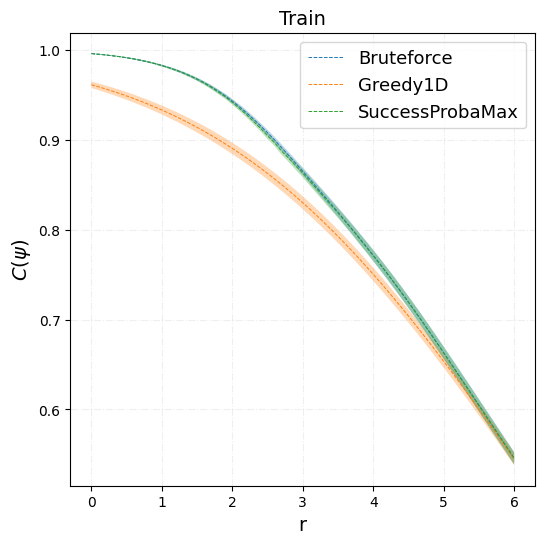

In [343]:
plt.figure(figsize=(6,6))
fontsize = 14

for m in methods[:]:#-1]:
    x_tr = np.mean(np.array([i[m] for i in splits_res_train]), axis=0)
    ci_tr = 2 * np.std(np.array([i[m] for i in splits_res_train]), axis=0) / np.sqrt(n_splits)
    plt.plot(
        Rs,
        # res_1d_train[m],
        x_tr,
        lw=0.7,
        ls='--',
        label=m#+'_train'
    )
    plt.fill_between(
        Rs,
        (x_tr-ci_tr),
        (x_tr+ci_tr),
        alpha=0.3
    )
    
    # x_test = np.mean(np.array([i[m] for i in splits_res_test]), axis=0)
    # ci_test = 2 * np.std(np.array([i[m] for i in splits_res_test]), axis=0) / np.sqrt(n_splits)
    # plt.plot(
    #     Rs,
    #     # res_1d_train[m],
    #     x_test,
    #     label=m+'_test'
    # )
    # plt.fill_between(
    #     Rs,
    #     (x_test-ci_test),
    #     (x_test+ci_test),
    #     alpha=0.3
    # )
    
plt.xlabel('r', fontsize=fontsize)
plt.ylabel('$C(\psi)$', fontsize=fontsize)
plt.grid(alpha=0.2, ls="-.")
plt.title('Train', fontsize=fontsize)
plt.legend(fontsize=fontsize-1)#, bbox_to_anchor=(0.5, 1.02), framealpha=1)
plt.show()

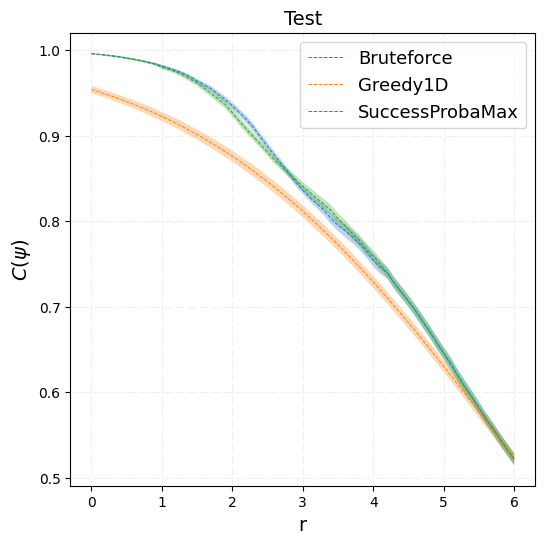

In [344]:
plt.figure(figsize=(6,6))
fontsize = 14

for m in methods[:]:#-1]:
    # x_tr = np.mean(np.array([i[m] for i in splits_res_train]), axis=0)
    # ci_tr = 2 * np.std(np.array([i[m] for i in splits_res_train]), axis=0) / np.sqrt(n_splits)
    # plt.plot(
    #     Rs,
    #     # res_1d_train[m],
    #     x_tr,
    #     lw=0.7,
    #     ls='--',
    #     label=m+'_train'
    # )
    # plt.fill_between(
    #     Rs,
    #     (x_tr-ci_tr),
    #     (x_tr+ci_tr),
    #     alpha=0.3
    # )
    
    x_test = np.mean(np.array([i[m] for i in splits_res_test]), axis=0)
    ci_test = 2 * np.std(np.array([i[m] for i in splits_res_test]), axis=0) / np.sqrt(n_splits)
    plt.plot(
        Rs,
        # res_1d_train[m],
        x_test,
        lw=0.7,
        ls='--',
        label=m#+'_test'
    )
    plt.fill_between(
        Rs,
        (x_test-ci_test),
        (x_test+ci_test),
        alpha=0.3
    )
    
plt.xlabel('r', fontsize=fontsize)
plt.ylabel('$C(\psi)$', fontsize=fontsize)
plt.grid(alpha=0.2, ls="-.")
plt.title('Test', fontsize=fontsize)
plt.legend(fontsize=fontsize-1)#, bbox_to_anchor=(0.5, 1.02), framealpha=1)
plt.show()

In [345]:
mu_0 = np.array([
    [2,1.9,0],
    [2,1,0],
    [2,1,0]
    ])

Sigma_mult = 1

Sigma_0 = Sigma_mult * np.array([
    [3,1,3],
    [3,1,3],
    [1,1,1]
])**2

nbucket, npol = mu_0.shape

np.random.seed(2480947)
    
N = 10000

df_sim = pd.DataFrame(
    {
        'X':np.random.choice(np.arange(nbucket), p=[1/3,1/3,1/3], size=N),
        'pi':np.random.choice(np.arange(npol), p=[1/3,1/3,1/3], size=N),
        'y':np.zeros(N)
    }
)

for i in range(N):
    df_sim['y'][i] = np.random.normal(mu_0[df_sim.X[i]][df_sim.pi[i]], np.sqrt(Sigma_0[df_sim.X[i]][df_sim.pi[i]]))

splits_res_train = []
splits_res_test = []
n_splits = 100

for _ in tqdm(range(n_splits)):

    df_sim = df_sim.sample(frac=1)
    df_sim_train = df_sim[:int(N/2)]
    df_sim_test = df_sim[int(N/2):]

    mu_0_train = df_sim_train.groupby(['X','pi']).mean().values.reshape(3,3)
    Sigma_0_train = df_sim_train.groupby(['X','pi']).var().values.reshape(3,3)

    mu_0_test = df_sim_test.groupby(['X','pi']).mean().values.reshape(3,3)
    Sigma_0_test = df_sim_test.groupby(['X','pi']).var().values.reshape(3,3)
    
    ### for hard bruteforce
    candidates = [list(comb) for comb in list(itertools.product([0., 1.], repeat=npol)) if sum(comb) == 1]
    all_hard_allocs = list(itertools.product(candidates, repeat=nbucket))

    ### greedy allocation
    greedy_alloc = greedy_1d(mu_0_train)
    
    Rs = np.arange(0, 6.1, 0.1)

    methods = ['Bruteforce', 'Greedy1D', 'SuccessProbaMax']# \n($\psi_0^{unif}$)', 'SuccessProbaMax \n($\psi_0$ from exploration)']
    # methods = ['Bruteforce', 'Greedy1D', 'SuccessProbaMax \n($\psi_0$ from exploration)']
    res_1d_train = {i:np.zeros_like(Rs) for i in methods}
    res_1d_test = {i:np.zeros_like(Rs) for i in methods}
    
    for i in range(len(Rs)):
    
        hard_bf_alloc = hard_bruteforce_1d_v3(all_hard_allocs, mu_0_train, Sigma_0_train, Rs[i])
        res_1d_train['Bruteforce'][i] = evaluate_1d_v2(hard_bf_alloc, mu_0_train, Sigma_0_train, Rs[i])
        res_1d_test['Bruteforce'][i] = evaluate_1d_v2(hard_bf_alloc, mu_0_test, Sigma_0_test, Rs[i])

        res_1d_train['Greedy1D'][i] = evaluate_1d_v2(greedy_alloc, mu_0_train, Sigma_0_train, Rs[i])
        res_1d_test['Greedy1D'][i] = evaluate_1d_v2(greedy_alloc, mu_0_test, Sigma_0_test, Rs[i])

        ### initial allocation to start SPM from 
        psi_0 = np.array([[1./npol]*npol]*nbucket) ### uniform allocation
        spm_unif_alloc = optimize_1d(Sigma_0_train, mu_0_train, Rs[i], psi_0, n_steps=10000, eta = 0.1)
        res_1d_train['SuccessProbaMax'][i] = evaluate_1d_v2(spm_unif_alloc, mu_0_train, Sigma_0_train, Rs[i])
        res_1d_test['SuccessProbaMax'][i] = evaluate_1d_v2(spm_unif_alloc, mu_0_test, Sigma_0_test, Rs[i])
        
    splits_res_train.append(res_1d_train)
    splits_res_test.append(res_1d_test)

/home/a.betlei/.local/share/jupyter/.python-kernel/python-kernel-54945/lib64/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 100/100 [11:01<00:00,  6.62s/it]


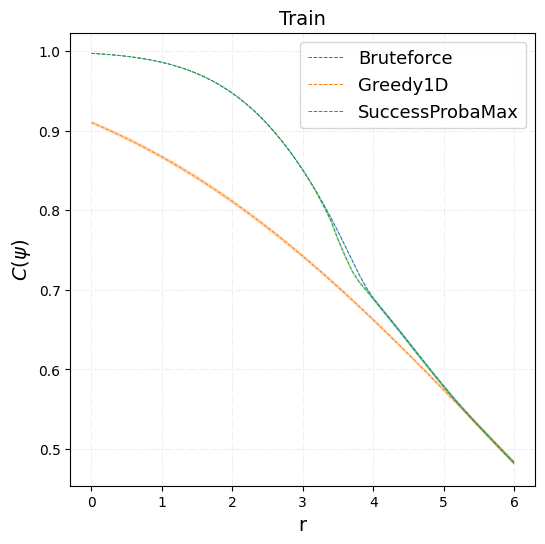

In [348]:
plt.figure(figsize=(6,6))
fontsize = 14

for m in methods[:]:#-1]:
    x_tr = np.mean(np.array([i[m] for i in splits_res_train]), axis=0)
    ci_tr = 2 * np.std(np.array([i[m] for i in splits_res_train]), axis=0) / np.sqrt(n_splits)
    plt.plot(
        Rs,
        # res_1d_train[m],
        x_tr,
        lw=0.7,
        ls='--',
        label=m#+'_train'
    )
    plt.fill_between(
        Rs,
        (x_tr-ci_tr),
        (x_tr+ci_tr),
        alpha=0.3
    )
    
    # x_test = np.mean(np.array([i[m] for i in splits_res_test]), axis=0)
    # ci_test = 2 * np.std(np.array([i[m] for i in splits_res_test]), axis=0) / np.sqrt(n_splits)
    # plt.plot(
    #     Rs,
    #     # res_1d_train[m],
    #     x_test,
    #     label=m+'_test'
    # )
    # plt.fill_between(
    #     Rs,
    #     (x_test-ci_test),
    #     (x_test+ci_test),
    #     alpha=0.3
    # )
    
plt.xlabel('r', fontsize=fontsize)
plt.ylabel('$C(\psi)$', fontsize=fontsize)
plt.grid(alpha=0.2, ls="-.")
plt.title('Train', fontsize=fontsize)
plt.legend(fontsize=fontsize-1)#, bbox_to_anchor=(0.5, 1.02), framealpha=1)
plt.show()

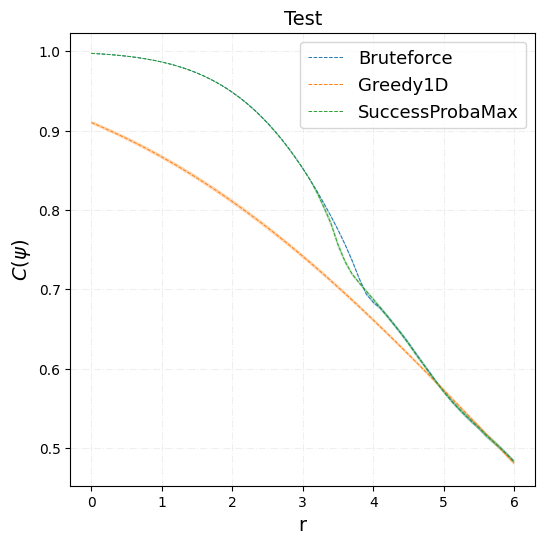

In [349]:
plt.figure(figsize=(6,6))
fontsize = 14

for m in methods[:]:#-1]:
    # x_tr = np.mean(np.array([i[m] for i in splits_res_train]), axis=0)
    # ci_tr = 2 * np.std(np.array([i[m] for i in splits_res_train]), axis=0) / np.sqrt(n_splits)
    # plt.plot(
    #     Rs,
    #     # res_1d_train[m],
    #     x_tr,
    #     lw=0.7,
    #     ls='--',
    #     label=m+'_train'
    # )
    # plt.fill_between(
    #     Rs,
    #     (x_tr-ci_tr),
    #     (x_tr+ci_tr),
    #     alpha=0.3
    # )
    
    x_test = np.mean(np.array([i[m] for i in splits_res_test]), axis=0)
    ci_test = 2 * np.std(np.array([i[m] for i in splits_res_test]), axis=0) / np.sqrt(n_splits)
    plt.plot(
        Rs,
        # res_1d_train[m],
        x_test,
        lw=0.7,
        ls='--',
        label=m#+'_test'
    )
    plt.fill_between(
        Rs,
        (x_test-ci_test),
        (x_test+ci_test),
        alpha=0.3
    )
    
plt.xlabel('r', fontsize=fontsize)
plt.ylabel('$C(\psi)$', fontsize=fontsize)
plt.grid(alpha=0.2, ls="-.")
plt.title('Test', fontsize=fontsize)
plt.legend(fontsize=fontsize-1)#, bbox_to_anchor=(0.5, 1.02), framealpha=1)
plt.show()

__Small__ variance compared to mean

In [352]:
mu_0 = np.array([
    [2,1.9,0],
    [2,1,0],
    [2,1,0]
    ])

Sigma_mult = 0.01

Sigma_0 = Sigma_mult * np.array([
    [3,1,3],
    [3,1,3],
    [1,1,1]
])**2

nbucket, npol = mu_0.shape

np.random.seed(2480947)
    
N = 1000

df_sim = pd.DataFrame(
    {
        'X':np.random.choice(np.arange(nbucket), p=[1/3,1/3,1/3], size=N),
        'pi':np.random.choice(np.arange(npol), p=[1/3,1/3,1/3], size=N),
        'y':np.zeros(N)
    }
)

for i in range(N):
    df_sim['y'][i] = np.random.normal(mu_0[df_sim.X[i]][df_sim.pi[i]], np.sqrt(Sigma_0[df_sim.X[i]][df_sim.pi[i]]))

splits_res_train = []
splits_res_test = []
n_splits = 100

for _ in tqdm(range(n_splits)):

    df_sim = df_sim.sample(frac=1)
    df_sim_train = df_sim[:int(N/2)]
    df_sim_test = df_sim[int(N/2):]
    # print(df_sim_train.index)

    mu_0_train = df_sim_train.groupby(['X','pi']).mean().values.reshape(3,3)
    Sigma_0_train = df_sim_train.groupby(['X','pi']).var(ddof=1).values.reshape(3,3)

    mu_0_test = df_sim_test.groupby(['X','pi']).mean().values.reshape(3,3)
    Sigma_0_test = df_sim_test.groupby(['X','pi']).var(ddof=1).values.reshape(3,3)
    
    ### for hard bruteforce
    candidates = [list(comb) for comb in list(itertools.product([0., 1.], repeat=npol)) if sum(comb) == 1]
    all_hard_allocs = list(itertools.product(candidates, repeat=nbucket))

    ### greedy allocation
    greedy_alloc = greedy_1d(mu_0_train)
    
    Rs = np.arange(4.5, 6.1, 0.1)

    methods = ['Bruteforce', 'Greedy1D', 'SuccessProbaMax \n($\psi_0$ from exploration)']
    res_1d_train = {i:np.zeros_like(Rs) for i in methods}
    res_1d_test = {i:np.zeros_like(Rs) for i in methods}
    
    for i in range(len(Rs)):
    
        hard_bf_alloc = hard_bruteforce_1d_v3(all_hard_allocs, mu_0_train, Sigma_0_train, Rs[i])
        res_1d_train['Bruteforce'][i] = evaluate_1d_v2(hard_bf_alloc, mu_0_train, Sigma_0_train, Rs[i])
        res_1d_test['Bruteforce'][i] = evaluate_1d_v2(hard_bf_alloc, mu_0_test, Sigma_0_test, Rs[i])

        res_1d_train['Greedy1D'][i] = evaluate_1d_v2(greedy_alloc, mu_0_train, Sigma_0_train, Rs[i])
        res_1d_test['Greedy1D'][i] = evaluate_1d_v2(greedy_alloc, mu_0_test, Sigma_0_test, Rs[i])
        
        spm_alloc = optimize_1d_v2(Sigma_0_train, mu_0_train, Rs[i], psi_0s, n_steps=10000, eta = 0.1)
        res_1d_train['SuccessProbaMax \n($\psi_0$ from exploration)'][i] = evaluate_1d_v2(spm_alloc, mu_0_train, Sigma_0_train, Rs[i])
        res_1d_test['SuccessProbaMax \n($\psi_0$ from exploration)'][i] = evaluate_1d_v2(spm_alloc, mu_0_test, Sigma_0_test, Rs[i])
        
    splits_res_train.append(res_1d_train)
    splits_res_test.append(res_1d_test)

/home/a.betlei/.local/share/jupyter/.python-kernel/python-kernel-54945/lib64/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  0%|          | 0/100 [00:00<?, ?it/s]

Int64Index([804, 453, 228, 283, 969, 269, 734, 463, 157,   2,
            ...
             49, 754,  58, 617, 244, 246, 946, 884, 879, 932],
           dtype='int64', length=500)


  1%|          | 1/100 [00:01<02:51,  1.73s/it]

Int64Index([146, 150, 694, 216, 321, 224, 301, 553, 120,   3,
            ...
            797, 957, 444, 861, 236, 178, 899, 270, 237, 447],
           dtype='int64', length=500)


  2%|▏         | 2/100 [00:03<02:49,  1.73s/it]

Int64Index([468, 287,  31, 150,  72, 777, 306, 639, 462, 383,
            ...
            498, 602, 401, 965, 145,  74,   7, 107, 955, 586],
           dtype='int64', length=500)


  3%|▎         | 3/100 [00:05<02:48,  1.73s/it]

Int64Index([431, 814, 950, 104, 898, 373, 698, 809,  99, 551,
            ...
            559, 609, 915, 836,   7, 821, 773,  66, 481, 380],
           dtype='int64', length=500)


  3%|▎         | 3/100 [00:06<03:36,  2.23s/it]


KeyboardInterrupt: 

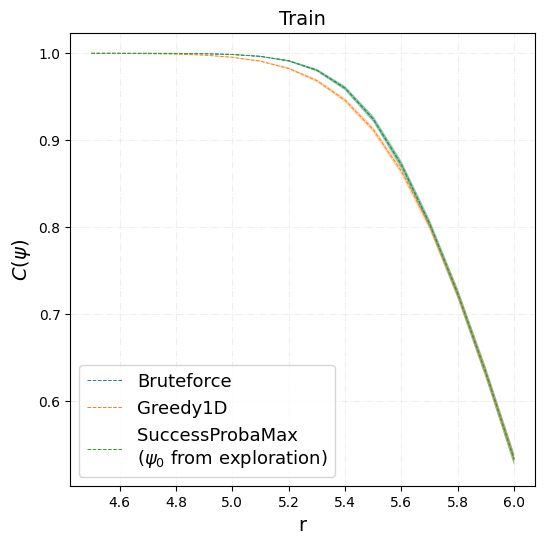

In [331]:
plt.figure(figsize=(6,6))
fontsize = 14

for m in methods[:]:#-1]:
    x_tr = np.mean(np.array([i[m] for i in splits_res_train]), axis=0)
    ci_tr = 2 * np.std(np.array([i[m] for i in splits_res_train]), axis=0) / np.sqrt(n_splits)
    plt.plot(
        Rs,
        # res_1d_train[m],
        x_tr,
        lw=0.7,
        ls='--',
        label=m#+'_train'
    )
    plt.fill_between(
        Rs,
        (x_tr-ci_tr),
        (x_tr+ci_tr),
        alpha=0.3
    )
    
    # x_test = np.mean(np.array([i[m] for i in splits_res_test]), axis=0)
    # ci_test = 2 * np.std(np.array([i[m] for i in splits_res_test]), axis=0) / np.sqrt(n_splits)
    # plt.plot(
    #     Rs,
    #     # res_1d_train[m],
    #     x_test,
    #     label=m+'_test'
    # )
    # plt.fill_between(
    #     Rs,
    #     (x_test-ci_test),
    #     (x_test+ci_test),
    #     alpha=0.3
    # )
    
plt.xlabel('r', fontsize=fontsize)
plt.ylabel('$C(\psi)$', fontsize=fontsize)
plt.grid(alpha=0.2, ls="-.")
plt.title('Train', fontsize=fontsize)
plt.legend(fontsize=fontsize-1)#, bbox_to_anchor=(0.5, 1.02), framealpha=1)
plt.show()

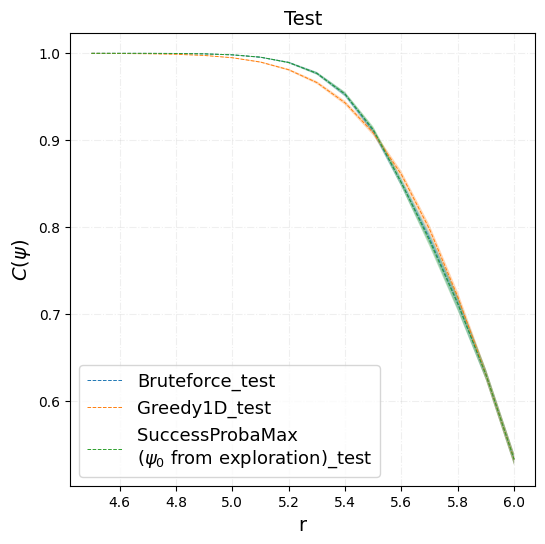

In [332]:
plt.figure(figsize=(6,6))
fontsize = 14

for m in methods[:]:#-1]:
    # x_tr = np.mean(np.array([i[m] for i in splits_res_train]), axis=0)
    # ci_tr = 2 * np.std(np.array([i[m] for i in splits_res_train]), axis=0) / np.sqrt(n_splits)
    # plt.plot(
    #     Rs,
    #     # res_1d_train[m],
    #     x_tr,
    #     lw=0.7,
    #     ls='--',
    #     label=m+'_train'
    # )
    # plt.fill_between(
    #     Rs,
    #     (x_tr-ci_tr),
    #     (x_tr+ci_tr),
    #     alpha=0.3
    # )
    
    x_test = np.mean(np.array([i[m] for i in splits_res_test]), axis=0)
    ci_test = 2 * np.std(np.array([i[m] for i in splits_res_test]), axis=0) / np.sqrt(n_splits)
    plt.plot(
        Rs,
        # res_1d_train[m],
        x_test,
        lw=0.7,
        ls='--',
        label=m+'_test'
    )
    plt.fill_between(
        Rs,
        (x_test-ci_test),
        (x_test+ci_test),
        alpha=0.3
    )
    
plt.xlabel('r', fontsize=fontsize)
plt.ylabel('$C(\psi)$', fontsize=fontsize)
plt.grid(alpha=0.2, ls="-.")
plt.title('Test', fontsize=fontsize)
plt.legend(fontsize=fontsize-1)#, bbox_to_anchor=(0.5, 1.02), framealpha=1)
plt.show()

In [333]:
mu_0 = np.array([
    [2,1.9,0],
    [2,1,0],
    [2,1,0]
    ])

Sigma_mult = 0.01

Sigma_0 = Sigma_mult * np.array([
    [3,1,3],
    [3,1,3],
    [1,1,1]
])**2

nbucket, npol = mu_0.shape

np.random.seed(2480947)
    
N = 10000

df_sim = pd.DataFrame(
    {
        'X':np.random.choice(np.arange(nbucket), p=[1/3,1/3,1/3], size=N),
        'pi':np.random.choice(np.arange(npol), p=[1/3,1/3,1/3], size=N),
        'y':np.zeros(N)
    }
)

for i in range(N):
    df_sim['y'][i] = np.random.normal(mu_0[df_sim.X[i]][df_sim.pi[i]], np.sqrt(Sigma_0[df_sim.X[i]][df_sim.pi[i]]))

splits_res_train = []
splits_res_test = []
n_splits = 100

for _ in tqdm(range(n_splits)):

    df_sim = df_sim.sample(frac=1)
    df_sim_train = df_sim[:int(N/2)]
    df_sim_test = df_sim[int(N/2):]

    mu_0_train = df_sim_train.groupby(['X','pi']).mean().values.reshape(3,3)
    Sigma_0_train = df_sim_train.groupby(['X','pi']).var().values.reshape(3,3)

    mu_0_test = df_sim_test.groupby(['X','pi']).mean().values.reshape(3,3)
    Sigma_0_test = df_sim_test.groupby(['X','pi']).var().values.reshape(3,3)
    
    ### for hard bruteforce
    candidates = [list(comb) for comb in list(itertools.product([0., 1.], repeat=npol)) if sum(comb) == 1]
    all_hard_allocs = list(itertools.product(candidates, repeat=nbucket))

    ### greedy allocation
    greedy_alloc = greedy_1d(mu_0_train)
    
    Rs = np.arange(4.5, 6.1, 0.1)

    methods = ['Bruteforce', 'Greedy1D', 'SuccessProbaMax \n($\psi_0$ from exploration)']
    res_1d_train = {i:np.zeros_like(Rs) for i in methods}
    res_1d_test = {i:np.zeros_like(Rs) for i in methods}
    
    for i in range(len(Rs)):
    
        hard_bf_alloc = hard_bruteforce_1d_v3(all_hard_allocs, mu_0_train, Sigma_0_train, Rs[i])
        res_1d_train['Bruteforce'][i] = evaluate_1d_v2(hard_bf_alloc, mu_0_train, Sigma_0_train, Rs[i])
        res_1d_test['Bruteforce'][i] = evaluate_1d_v2(hard_bf_alloc, mu_0_test, Sigma_0_test, Rs[i])

        res_1d_train['Greedy1D'][i] = evaluate_1d_v2(greedy_alloc, mu_0_train, Sigma_0_train, Rs[i])
        res_1d_test['Greedy1D'][i] = evaluate_1d_v2(greedy_alloc, mu_0_test, Sigma_0_test, Rs[i])
        
        spm_alloc = optimize_1d_v2(Sigma_0_train, mu_0_train, Rs[i], psi_0s, n_steps=10000, eta = 0.1)
        res_1d_train['SuccessProbaMax \n($\psi_0$ from exploration)'][i] = evaluate_1d_v2(spm_alloc, mu_0_train, Sigma_0_train, Rs[i])
        res_1d_test['SuccessProbaMax \n($\psi_0$ from exploration)'][i] = evaluate_1d_v2(spm_alloc, mu_0_test, Sigma_0_test, Rs[i])
        
    splits_res_train.append(res_1d_train)
    splits_res_test.append(res_1d_test)

/home/a.betlei/.local/share/jupyter/.python-kernel/python-kernel-54945/lib64/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 100/100 [02:53<00:00,  1.74s/it]


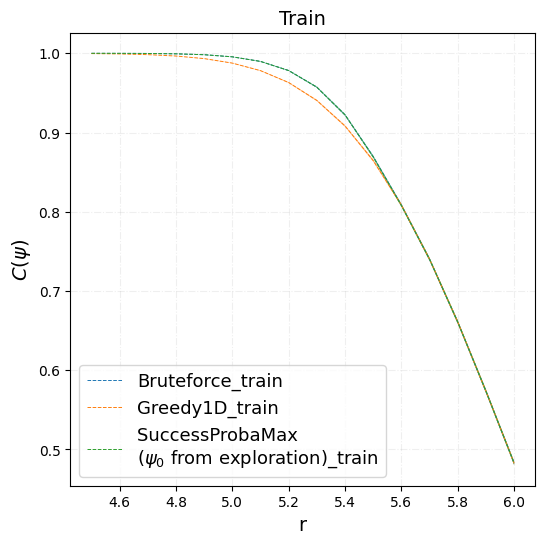

In [336]:
plt.figure(figsize=(6,6))
fontsize = 14

for m in methods[:]:#-1]:
    x_tr = np.mean(np.array([i[m] for i in splits_res_train]), axis=0)
    ci_tr = 2 * np.std(np.array([i[m] for i in splits_res_train]), axis=0) / np.sqrt(n_splits)
    plt.plot(
        Rs,
        # res_1d_train[m],
        x_tr,
        lw=0.7,
        ls='--',
        label=m+'_train'
    )
    plt.fill_between(
        Rs,
        (x_tr-ci_tr),
        (x_tr+ci_tr),
        alpha=0.5
    )
    
    # x_test = np.mean(np.array([i[m] for i in splits_res_test]), axis=0)
    # ci_test = 2 * np.std(np.array([i[m] for i in splits_res_test]), axis=0) / np.sqrt(n_splits)
    # plt.plot(
    #     Rs,
    #     # res_1d_train[m],
    #     x_test,
    #     label=m+'_test'
    # )
    # plt.fill_between(
    #     Rs,
    #     (x_test-ci_test),
    #     (x_test+ci_test),
    #     alpha=0.3
    # )
    
plt.xlabel('r', fontsize=fontsize)
plt.ylabel('$C(\psi)$', fontsize=fontsize)
plt.grid(alpha=0.2, ls="-.")
plt.title('Train', fontsize=fontsize)
plt.legend(fontsize=fontsize-1)#, bbox_to_anchor=(0.5, 1.02), framealpha=1)
plt.show()

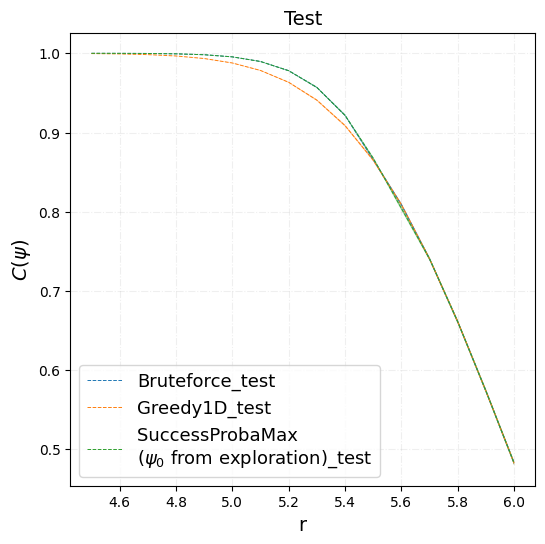

In [337]:
plt.figure(figsize=(6,6))
fontsize = 14

for m in methods[:]:#-1]:
    # x_tr = np.mean(np.array([i[m] for i in splits_res_train]), axis=0)
    # ci_tr = 2 * np.std(np.array([i[m] for i in splits_res_train]), axis=0) / np.sqrt(n_splits)
    # plt.plot(
    #     Rs,
    #     # res_1d_train[m],
    #     x_tr,
    #     lw=0.7,
    #     ls='--',
    #     label=m+'_train'
    # )
    # plt.fill_between(
    #     Rs,
    #     (x_tr-ci_tr),
    #     (x_tr+ci_tr),
    #     alpha=0.3
    # )
    
    x_test = np.mean(np.array([i[m] for i in splits_res_test]), axis=0)
    ci_test = 2 * np.std(np.array([i[m] for i in splits_res_test]), axis=0) / np.sqrt(n_splits)
    plt.plot(
        Rs,
        # res_1d_train[m],
        x_test,
        lw=0.7,
        ls='--',
        label=m+'_test'
    )
    plt.fill_between(
        Rs,
        (x_test-ci_test),
        (x_test+ci_test),
        alpha=0.5
    )
    
plt.xlabel('r', fontsize=fontsize)
plt.ylabel('$C(\psi)$', fontsize=fontsize)
plt.grid(alpha=0.2, ls="-.")
plt.title('Test', fontsize=fontsize)
plt.legend(fontsize=fontsize-1)#, bbox_to_anchor=(0.5, 1.02), framealpha=1)
plt.show()